In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools

In [3]:
load_file_path=os.path.join('/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline Mnist', 'Copy of Baseline Mnist 3*3.csv')
print(load_file_path)

save_folder='/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline Mnist/processed data'

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline Mnist/Copy of Baseline Mnist 3*3.csv


In [4]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)
dataframe

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,branch1.0,branch1.1,branch2.0,branch2.1,branch3.0,branch3.1,train accuracy epoch0,test accuracy epoch0,method,run
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,269.099950,269.100000,139.885210,139.885250,177.304870,177.304890,92.573333,95.33,deeplift,0
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,398.740309,398.740312,243.638798,243.638788,297.242188,297.242201,92.573333,95.33,integrated_gradients,0
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,415.727200,415.727200,165.776800,165.776800,309.423920,309.423920,92.366667,96.44,deeplift,1
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,405.272915,405.272931,220.079302,220.079306,373.220360,373.220366,92.366667,96.44,integrated_gradients,1
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,221.465600,221.465590,159.015930,159.015930,492.336850,492.336850,92.290000,95.86,deeplift,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,460.216816,460.216808,199.555394,199.555394,225.685888,225.685891,92.791667,94.54,integrated_gradients,12
536,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,308.286220,308.286220,423.473820,423.473850,605.610600,605.610350,92.911667,95.46,deeplift,13
537,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,213.670668,213.670669,303.919104,303.919119,456.312258,456.312256,92.911667,95.46,integrated_gradients,13
538,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,678.112300,678.112240,553.610300,553.610200,950.149350,950.149200,92.670000,94.22,deeplift,14


add flops col

In [5]:
def preprocess_dataframe(df, flops_dict):
    # Step 1: Modify column names and remove specific columns
    #df.rename(columns={'conv1x1_3x3.1': 'conv1x1_3x3', 'conv1x1_5x5.1': 'conv1x1_5x5'}, inplace=True)
    #df.drop(columns=['conv1x1_3x3.0', 'conv1x1_5x5.0'], inplace=True)

    # Step 2: Add FLOPS columns
    for col, value in flops_dict.items():
        df[col] = value

    return df

# Example usage:
flops_dict = {"branch1.0FLOPS": 0.9093, "branch2.0FLOPS": 0.9093, "branch3.0FLOPS": 0.9093, "totalFLOPS": 12.365}
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [6]:
def normalize_feature_attribution_final(df):
    """
    Final modification of the normalization of feature attributions for each layer.

    Parameters:
    df (DataFrame): The dataframe containing the feature attributions.

    Returns:
    DataFrame: A modified dataframe with normalized feature attributions for each layer.
    """
    # Columns to be normalized
    layers = ['branch1.0','branch2.0','branch3.0']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']

    df.drop(['sum_feature_attr','branch1.0','branch2.0','branch3.0'], axis=1, inplace=True)

    return df

# Example usage of the final modified function
normalized_final_df = normalize_feature_attribution_final(df.copy())

get average and normalzied variance for each combination of hyperparameter

In [7]:
def calculate_normalized_variance(df, method, flops_dict):
    """
    Modified combined function to calculate the average and normalized variance of each layer's feature attribution
    for a given method, including both average and variance in one dataframe, along with average accuracy after each epoch.
    This version also includes FLOPS information.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    method (str): The method to filter the data ('deeplift' or 'integrated_gradients').
    flops_dict (dict): Dictionary containing FLOPS values for different layers.

    Returns:
    DataFrame: A dataframe with the average and normalized variance for each layer combined, and average accuracy after each epoch, including FLOPS info.
    """
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_branch1.0','norm_branch2.0','norm_branch3.0']
    accuracy_columns = ['train accuracy epoch0', 'test accuracy epoch0']

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var_norm = grouped[layers].var()
    avg_acc = grouped[accuracy_columns].mean()

    # Calculate normalized variance (variance/mean)
    norm_var = var_norm / avg_norm

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'norm_var_{layer}'] = norm_var[layer]

    # Calculate the average normalized variance across the selected layers
    norm_var_layers = [f'norm_var_{layer}' for layer in layers]
    combined_df['avg_normalized_variance'] = combined_df[norm_var_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
combined_avg_norm_var_acc_deeplift = calculate_normalized_variance(normalized_final_df, 'deeplift', flops_dict)

In [8]:
combined_avg_norm_var_acc_deeplift.to_csv(save_folder+"/Baseline mnist 3*3 dl.csv")
combined_avg_norm_var_acc_deeplift=pd.read_csv(save_folder+"/Baseline mnist 3*3 dl.csv")

In [9]:
def filter_by_accuracy(df, threshold=70.0):
    """
    Function to filter out rows where the average accuracy across epoch 3 (both train and test) is lower than a specified threshold.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    threshold (float): The threshold for average accuracy in epoch 3.

    Returns:
    DataFrame: A filtered dataframe with rows having average epoch 3 accuracy higher than the threshold.
    """
    # Columns representing epoch 3 accuracy
    epoch_2_accuracy_cols = ['test accuracy epoch0']

    # Calculate the average accuracy for epoch 3
    df['final_test_accuracy'] = df[epoch_2_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return filtered_df

# Apply the function to the dataframes for 'deeplift' and 'integrated_gradients'
filtered_deeplift = filter_by_accuracy(combined_avg_norm_var_acc_deeplift)

# Display the first few rows of the filtered dataframes
filtered_deeplift

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_branch1.0,norm_branch2.0,norm_branch3.0,norm_var_norm_branch1.0,norm_var_norm_branch2.0,norm_var_norm_branch3.0,avg_normalized_variance,train accuracy epoch0,test accuracy epoch0,branch1.0FLOPS,branch2.0FLOPS,branch3.0FLOPS,totalFLOPS,final_test_accuracy
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.339888,0.284221,0.375891,0.043463,0.036125,0.047048,0.042212,93.059889,94.460000,0.9093,0.9093,0.9093,12.365,94.460000
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.332749,0.284903,0.382348,0.042044,0.037265,0.044599,0.041303,91.997667,94.742000,0.9093,0.9093,0.9093,12.365,94.742000
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.334576,0.287977,0.377447,0.038238,0.034407,0.040041,0.037562,90.746000,94.460667,0.9093,0.9093,0.9093,12.365,94.460667
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.334338,0.289553,0.376109,0.043166,0.043529,0.050476,0.045724,92.974222,96.046667,0.9093,0.9093,0.9093,12.365,96.046667
4,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.338931,0.284982,0.376087,0.038466,0.042367,0.045286,0.042040,92.145889,95.815333,0.9093,0.9093,0.9093,12.365,95.815333
5,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.332596,0.286700,0.380705,0.039853,0.035355,0.042869,0.039359,90.886333,95.490000,0.9093,0.9093,0.9093,12.365,95.490000
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.322308,0.283544,0.394148,0.057672,0.044605,0.063484,0.055254,92.897111,93.511333,0.9093,0.9093,0.9093,12.365,93.511333
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.337119,0.277056,0.385826,0.053522,0.047707,0.058872,0.053367,92.300889,94.043333,0.9093,0.9093,0.9093,12.365,94.043333
8,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.327226,0.290469,0.382305,0.046829,0.049822,0.052203,0.049618,91.494778,94.178000,0.9093,0.9093,0.9093,12.365,94.178000
9,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.329577,0.281338,0.389085,0.051590,0.060566,0.080430,0.064195,92.888000,95.314667,0.9093,0.9093,0.9093,12.365,95.314667


# Graph

In [10]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    """
    Plots bar graphs of the average variance of each layer and the overall average variance
    for multiple values of a given hyperparameter.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    hyperparam (str): The hyperparameter to vary.
    variables (list): A list of values for the hyperparameter to compare.

    Returns:
    None: The function plots graphs directly.
    """
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'norm_var' in col]
    variance_columns.append('avg_normalized_variance')

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


In [11]:
filtered_deeplift.to_csv(save_folder+"/Baseline mnist 3*3 dl ave var.csv")

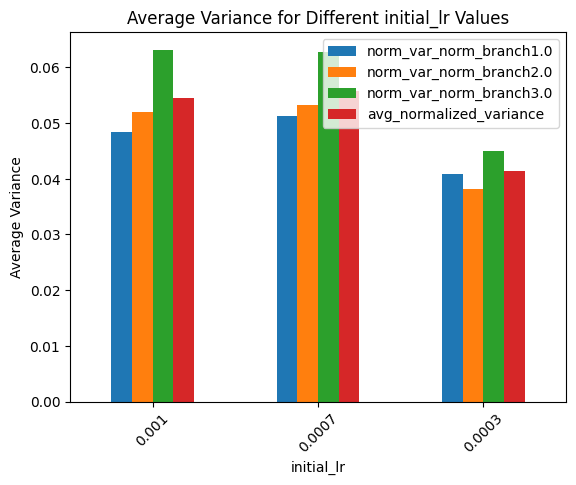

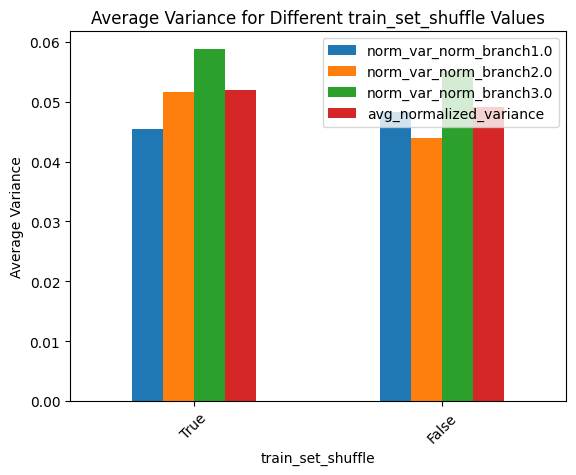

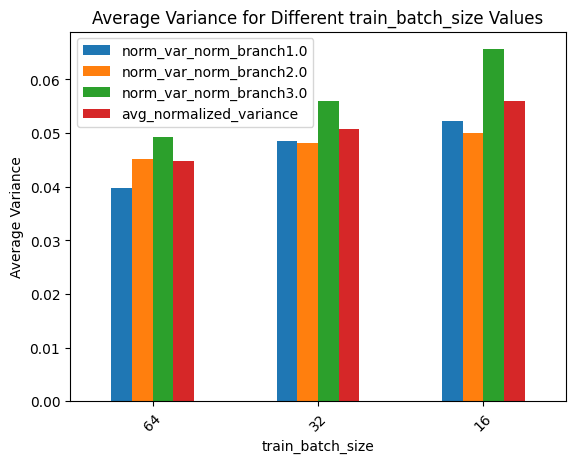

In [12]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_set_shuffle': [True,False],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(filtered_deeplift, hyperparam, variables)

# T test

In [13]:
def perform_t_test(df, target_column, condition_column, choice1, choice2):
    # Splitting the data into two groups based on the condition
    group1 = df[df[condition_column] == choice1][target_column]
    group2 = df[df[condition_column] == choice2][target_column]

    # Performing the independent t-test
    t_statistic, p_value = ttest_ind(group1, group2)

    return t_statistic, p_value

initial_lr

In [14]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -0.2784912177211184 P-value: 0.7863090986433039


In [15]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 3.4790871952239324 P-value: 0.005930247534470458


In [16]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 5.7327064321717 P-value: 0.00018960345564476584


train_set_shuffle

In [17]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_set_shuffle', True, False)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 0.6663225380494144 P-value: 0.514698595673628


train_batch_size

In [18]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 64, 32)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -1.568411997872407 P-value: 0.14785620867855076


In [19]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 64, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -2.363371468425296 P-value: 0.03972407495433646


In [20]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 32, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -1.0008172945228204 P-value: 0.34051673898527113


# Paired T test

In [21]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [22]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [23]:
def generate_hyperparameter_combinations(hyperparams):
    """
    Generate a sequence of hyperparameter combinations.

    :param hyperparams: A dictionary where keys are the names of hyperparameters,
                        and values are lists of possible choices for each hyperparameter.
    :return: A list of dictionaries, each representing a unique combination of hyperparameters.
    """
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [24]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

initial_lr

In [25]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0449782395540795 0.0517343498785186
0.0520827544635284 0.059934930514973
0.0673505928628819 0.0641953648200324
0.0454751378351644 0.0496179741553613
0.0560287582293358 0.0533669813290321
0.0611142395339645 0.0552538540086299
T-statistic: -0.4989279876823172 One-sided P-value: 0.6804989238517534


In [26]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0517343498785186 0.03935912701562
0.059934930514973 0.0420395132522328
0.0641953648200324 0.0457236493342619
0.0496179741553613 0.0375618670620955
0.0533669813290321 0.0413026792266988
0.0552538540086299 0.0422120127692561
T-statistic: 11.606669344967608 One-sided P-value: 4.166783283314105e-05


In [27]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0449782395540795 0.03935912701562
0.0520827544635284 0.0420395132522328
0.0673505928628819 0.0457236493342619
0.0454751378351644 0.0375618670620955
0.0560287582293358 0.0413026792266988
0.0611142395339645 0.0422120127692561
T-statistic: 5.073068491477413 One-sided P-value: 0.0019285095128991562


train_set_shuffle

In [28]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_set_shuffle', True, False)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0449782395540795 0.0454751378351644
0.0520827544635284 0.0560287582293358
0.0673505928628819 0.0611142395339645
0.0517343498785186 0.0496179741553613
0.059934930514973 0.0533669813290321
0.0641953648200324 0.0552538540086299
0.03935912701562 0.0375618670620955
0.0420395132522328 0.0413026792266988
0.0457236493342619 0.0422120127692561
T-statistic: 2.136062226622864 One-sided P-value: 0.03258742381422453


train_batch_size

In [29]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 32, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0520827544635284 0.0449782395540795
0.0560287582293358 0.0454751378351644
0.059934930514973 0.0517343498785186
0.0533669813290321 0.0496179741553613
0.0420395132522328 0.03935912701562
0.0413026792266988 0.0375618670620955
T-statistic: 4.747792971354892 One-sided P-value: 0.002557267882698513


In [30]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 32)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0673505928628819 0.0520827544635284
0.0611142395339645 0.0560287582293358
0.0641953648200324 0.059934930514973
0.0552538540086299 0.0533669813290321
0.0457236493342619 0.0420395132522328
0.0422120127692561 0.0413026792266988
T-statistic: 2.452631907272791 One-sided P-value: 0.028874601797567727


In [31]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0673505928628819 0.0449782395540795
0.0611142395339645 0.0454751378351644
0.0641953648200324 0.0517343498785186
0.0552538540086299 0.0496179741553613
0.0457236493342619 0.03935912701562
0.0422120127692561 0.0375618670620955
T-statistic: 3.927877279818697 One-sided P-value: 0.005546952853917498


#layer feature attribution rank frequency comparison

In [32]:
normalized_df = normalized_final_df[normalized_final_df['method'] == 'deeplift']
normalized_df_highacc = filter_by_accuracy(normalized_df)
normalized_df_highacc

<ipython-input-9-78e4492ffc89>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_test_accuracy'] = df[epoch_2_accuracy_cols].mean(axis=1)


,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,branch1.1,branch2.1,branch3.1,train accuracy epoch0,...,method,run,branch1.0FLOPS,branch2.0FLOPS,branch3.0FLOPS,totalFLOPS,norm_branch1.0,norm_branch2.0,norm_branch3.0,final_test_accuracy
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,269.10000,139.88525,177.30489,92.573333,...,deeplift,0,0.9093,0.9093,0.9093,12.365,0.458988,0.238594,0.302418,95.33
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,415.72720,165.77680,309.42392,92.366667,...,deeplift,1,0.9093,0.9093,0.9093,12.365,0.466623,0.186072,0.347305,96.44
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,221.46559,159.01593,492.33685,92.290000,...,deeplift,2,0.9093,0.9093,0.9093,12.365,0.253736,0.182187,0.564077,95.86
6,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,381.44324,429.08807,90.99310,92.238333,...,deeplift,3,0.9093,0.9093,0.9093,12.365,0.423109,0.475958,0.100932,95.99
8,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,343.06168,309.41815,299.49503,92.135000,...,deeplift,4,0.9093,0.9093,0.9093,12.365,0.360368,0.325028,0.314604,96.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,289.23547,447.40137,638.94574,93.313333,...,deeplift,10,0.9093,0.9093,0.9093,12.365,0.210264,0.325245,0.464491,91.86
532,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,355.39966,623.30927,782.07520,92.935000,...,deeplift,11,0.9093,0.9093,0.9093,12.365,0.201842,0.353995,0.444163,94.18
534,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,719.51900,325.84686,378.15740,92.791667,...,deeplift,12,0.9093,0.9093,0.9093,12.365,0.505449,0.228902,0.265649,94.54
536,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,308.28622,423.47385,605.61035,92.911667,...,deeplift,13,0.9093,0.9093,0.9093,12.365,0.230517,0.316647,0.452837,95.46


In [33]:
# Select the columns of interest
cols_of_interest = ['norm_branch1.0', 'norm_branch2.0', 'norm_branch3.0']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-33-85bc6b39743e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


213    78
123    62
312    61
321    36
231    18
132    15
Name: rank_combination, dtype: int64